<a href="https://colab.research.google.com/github/Erickrus/leetcode/blob/master/DiffusionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models
This is an easy-to-understand implementation of diffusion models within 100 lines of code. Different from other implementations, this code doesn't use the lower-bound formulation for sampling and strictly follows Algorithm 1 from the [DDPM](https://arxiv.org/pdf/2006.11239.pdf) paper, which makes it extremely short and easy to follow. There is only one implementation: `unconditional` in this notebook. Below you can find two explanation videos for the theory behind diffusion models and the implementation.

<a href="https://www.youtube.com/watch?v=HoKDTa5jHvg">
   <img alt="Qries" src="https://user-images.githubusercontent.com/61938694/191407922-f613759e-4bea-4ac9-9135-d053a6312421.jpg"
   width="300">
</a>

<a href="https://www.youtube.com/watch?v=TBCRlnwJtZU">
   <img alt="Qries" src="https://user-images.githubusercontent.com/61938694/191407849-6d0376c7-05b2-43cd-a75c-1280b0e33af1.png"
   width="300">
</a>

<hr>


### prepare CIFAR-10 dataset

In [6]:
#@title download CIFAR-10 dataset
%cd /content
!rm -Rf /content/ddpm
!rm -Rf /content/CIFAR-10-images
!git clone https://github.com/YoongiKim/CIFAR-10-images
!mkdir -p /content/ddpm/dataset


/content
Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 2.54 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


In [38]:
#@title shrink dataset size
#@markdown Image to keep per category

import glob, os
from tqdm import tqdm

nImageToKeep = 9999 #@param {"type":"integer"}

srcDir = '/content/CIFAR-10-images/test/'
tgtDir = '/content/ddpm/dataset/'
categoryNames = [os.path.basename(x[0]) for x in os.walk(srcDir)]
os.system("rm -Rf %s" % tgtDir)
os.system("mkdir -p %s" % tgtDir)
for categoryName in categoryNames:
  os.system("mkdir -p %s" % os.path.join(tgtDir, categoryName))

print("shrink CIFAR-10 dataset to %d per category %s" %(nImageToKeep, tgtDir))

for filename in tqdm(glob.glob(os.path.join(srcDir, "**", "*.jpg"))):
  shortFilename = os.path.basename(filename).replace(".jpg","")
  categoryName = filename.split("/")[-2]
  fileId = int(shortFilename)
  if fileId < nImageToKeep:
    os.system("cp -f %s %s" % (filename, os.path.join(tgtDir, categoryName)))
print("\n",len(glob.glob(os.path.join(tgtDir, "**", "*.jpg"))), "images left")


shrink CIFAR-10 dataset to 9999 per category /content/ddpm/dataset/


100%|██████████| 10000/10000 [14:13<00:00, 11.72it/s]



 10000 images left


### modules.py

In [39]:
#@title SelfAttention
#@markdown self attention
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


In [40]:
#@title DoubleConv
#@markdown double convolution
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)



In [41]:
#@title Down
#@markdown downsample process
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [42]:
#@title Up
#@markdown upsample process
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [43]:
#@title UNet
#@markdown UNet is $\epsilon_{\theta}(x_t,t)$
#@markdown
#@markdown <img src="https://huggingface.co/blog/assets/78_annotated-diffusion/unet_architecture.jpg" width="600px">
#@markdown 
#@markdown The author went for a U-Net, introduced by (Ronneberger et al., 2015) (which, at the time, achieved state-of-the-art results for medical image segmentation). This network, like any autoencoder, consists of a bottleneck in the middle that makes sure the network learns only the most important information. Importantly, it introduced residual connections between the encoder and decoder, greatly improving gradient flow (inspired by ResNet in He et al., 2015).
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

###utils.py

In [44]:
#@title utils.py
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

#@markdown plot_images
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

#@markdown save_images
def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)
    display(im)

#@markdown get_data
def get_data(args):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

#@markdown setup_logging
def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

###Diffusion Class

In [32]:
#@title Reparameterization Trick
import datetime
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
#import logging
from torch.utils.tensorboard import SummaryWriter

#logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    #@markdown `Diffusion.__init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda")`
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        #@markdown define linear beta model
        #@markdown > use `Diffusion.prepare_noise_schedule()`
        #@markdown > and $\beta_{1:T}$ basically just linspace($\beta_{start}$, $\beta_{end}$, $T$)
        #@markdown > <img src='https://lilianweng.github.io/posts/2021-07-11-diffusion-models/diffusion-beta.png' width=350px>
        self.beta = self.prepare_noise_schedule().to(device)
        #@markdown 
        #@markdown DDPM Section 2: **Background**

        #@markdown > formula (2): $q(x_{1:T}|x_0) := \displaystyle\prod_{t=1}^{T}q(x_t|x_{t−1})$
        #@markdown > $q(x_{t}|x_{t-1}) := N (x_t;\sqrt{1 − \beta_t}x_{t−1}, \beta_tI)$ 


        #@markdown 
        #@markdown > formula (4): $q(x_t|x_0)=N(x_t;\sqrt{\bar\alpha_t}x_0,(1-\bar\alpha_t)I)$  
        #@markdown 

        #@markdown >> **reparameterization trick**
        #@markdown
        #@markdown >> Let $\alpha_t=1-\beta_t$
        self.alpha = 1. - self.beta
        #@markdown >> Let $\bar\alpha=\displaystyle\prod^{t}_{s=1}\alpha_s$, accumulative product of $\alpha$
        #@markdown
        #@markdown >> *Notes: In the code, $\bar\alpha$ is called as alpha_hat, which is not proper*
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        #@markdown >> **derivations**
        #@markdown
        #@markdown >> $x_t=\sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon_{t-1}$
        #@markdown >> ; where $\epsilon_{t-1}, \epsilon_{t-2}, ... \sim N(0,I)$

        #@markdown >> $=\sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\bar\epsilon_{t-2}$
        #@markdown >> ; where $\bar\epsilon_{t-2}$ merges 2 Gaussians $(*)$.

        #@markdown
        #@markdown >> $=\ ...$
        #@markdown
        #@markdown >> $=\sqrt{\alpha_t\alpha_{t-1}...\alpha_{0}}x_0 + \sqrt{1-\alpha_t\alpha_{t-1}...\alpha_0}\epsilon$
        #@markdown
        #@markdown >> $=\sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar\alpha_t}\epsilon$

        #@markdown >> After a series of derivations, we get: 
        #@markdown >> $x_t = \sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon$ ; which means 
        #@markdown >> $q(x_t|x_0)=N(x_t;\sqrt{\bar\alpha_t}x_0,(1-\bar\alpha_t)I)$


        #@markdown >> (*) Recall that when we merge two Gaussians with different variance, $N(0,\sigma^2_1I)$ and $N(0,\sigma^2_2I)$
        #@markdown >> , the new distribution is $N(0,(\sigma^2_1+\sigma^2_2)I)$. Here the merged standard deviation is $\sqrt{(1-\alpha_t)-\alpha_t(1-\alpha_{t-1})}=\sqrt{1-\alpha_t\alpha_{t-1}}$
        #@markdown >> 
        #@markdown >> Usually, we can afford a larger update step when the sample gets noisier, so $\beta_1<\beta_2<...<\beta_T$ and therefore $\bar\alpha_1 > ... > \bar\alpha_T$




        '''
        #markdown > formula (6): $q(x_{t−1}|x_t, x_0) = N (x_{t−1}; \tilde\mu_t(x_t, x_0), \tilde\beta_tI),$
        #markdown 
        #markdown > formula (7): where $\tilde\mu_t(x_t, x_0) := \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}x_t$
        #markdown > and $\tilde\beta_t:=\frac{{1-\bar\alpha_{t-1}}}{1-\bar\alpha_t}\beta_t$
        '''

In [33]:
#@title prepare_noise_schedule, noise_images, sample_timesteps


#@markdown `Diffusion.prepare_noise_schedule()` Linear Schedule
#@markdown
#@markdown > simply get linspace values from $\beta_{start}$ to $\beta_{end}$ with $T$ noise steps
def prepare_noise_schedule(self):
    #@markdown > If you want to change it to cosine schedule like what OpenAI does, 
    #@markdown > it should be easy to do it here
    return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

#@markdown `Diffusion.noise_images(x, t)`
def noise_images(self, x, t):
    #@markdown > a) samples $\epsilon$ from $N(0,I)$
    e = torch.randn_like(x)
    #@markdown > b) forward process $q(x_t|x_{0})$: calculates $T$ diffusion steps in one shot, that is $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon$
    #@markdown >> super cool and fast
    sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
    
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * e, e

#@markdown `Diffusion.sample_timesteps(n)`
#@markdown > sample $T$ from $Uniform(\{1,...,T\})$
def sample_timesteps(self, n):
    return torch.randint(low=1, high=self.noise_steps, size=(n,))



Diffusion.prepare_noise_schedule = prepare_noise_schedule
Diffusion.noise_images = noise_images
Diffusion.sample_timesteps = sample_timesteps


**Forward process** and **Backward process**:

*   a fixed (or predefined) forward diffusion process $q$ of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise
*   a learned reverse denoising diffusion process $p_{\theta}$, where a neural network is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.



<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/diffusion_figure.png" />

Both the **forward** and **backward process** indexed by $t$ happen for some number of finite time steps $T$ (the DDPM authors use $T=1000$). You start with $t=0$ where you sample a real image $x_0$
 from your data distribution (let's say an image of a cat from ImageNet), and the forward process samples some noise from a Gaussian distribution at each time step $t$, which is added to the image of the previous time step. Given a sufficiently large $T$ and a well behaved schedule for adding noise at each time step, you end up with what is called an [isotropic Gaussian](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) distribution at $t=T$ via a gradual process.

In [34]:
#@title Algorithm 2 Sampling

def sample(self, model, n):
    print(datetime.datetime.now(), f"sample {n} new images....")
    #@markdown <img src="https://huggingface.co/blog/assets/78_annotated-diffusion/sampling.png" width="400px"/>
    #@markdown
    #@markdown **Algorithm 2** Sampling
    #@markdown 
    #@markdown ---------------     
    model.eval()
    with torch.no_grad():
        #@markdown 1: $x_T \sim N(0,I)$
        #@markdown
        #@markdown > sample from Gaussian distribution
        #@markdown
        #@markdown > the shape of $x_T$ is exactly the same as images: `(n, 3, img_size, img_size)`
        x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
        #@markdown 2: for $t=T,...,1$ do
        #@markdown
        #@markdown that is to execute T times the **backward process** $p(x_{t-1}|x_t)$ 
        for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
            #@markdown > 3: $z \sim N(0,I)$ if $t>1$, else $z=0$
            t = (torch.ones(n) * i).long().to(self.device)
            #@markdown > 4: $x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\alpha_t}}\epsilon_{\theta}(x_t,t))$
            #@markdown 
            #@markdown >> `model(x, t)` or `predicted_noise` is acutally the $\epsilon_{\theta}(x_t,t)$
            #@markdown 
            #@markdown >> Notice, we dont have $ + \sigma_tz$ in the end, this is because the author think variance is not needed
            predicted_noise = model(x, t)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            #@markdown 5: end for
    model.train()
    #@markdown 6: return $x_0$
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

Diffusion.sample = sample

In [45]:
#@title Algorithm 1 Training
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.tensorboard import SummaryWriter
import IPython
import numpy as np

def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)	
    #@markdown <img src="https://huggingface.co/blog/assets/78_annotated-diffusion/training.png" width="400px"/>
    #@markdown 
    #@markdown **Algorithm 1** Training
    #@markdown
    #@markdown ---------------	
    #@markdown 1: repeat
    for epoch in range(args.epochs):
        #IPython.display.clear_output(wait=True)
        print(datetime.datetime.now(), f"epoch: {epoch}:")
        # load data loops and augument a little bit
        print(datetime.datetime.now(), "train")
        pbar = tqdm(dataloader)
        losses = []
        # for each mini batch
        for i, (images, _) in enumerate(pbar):
            #@markdown > 2: $x_0 \sim q(x_0)$
            #@markdown >> sample `images` = $x_0$ from dataset
            images = images.to(device)
            #@markdown > 3: $t \sim Uniform(\{1,...,T\})$ 
            #@markdown >> sample timesteps `t` for all images at once
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            
            #@markdown > 4: $\epsilon \sim N(0,I)$
            #@markdown > 
            #@markdown > `noise_images(images, t)` does 2 things here:
            #@markdown >> 
            #@markdown >> a) samples $\epsilon$ from $N(0,I)$
            #@markdown >> 
            #@markdown >> b) **forward process** $q(x_t|x_{0})$: calculates $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon$
            x_t, noise = diffusion.noise_images(images, t)

            #@markdown > 5: Take gradient descent step on
            #@markdown 
            #@markdown >> use model (we use UNet() as $\epsilon_{\theta}()$) to predict the noise, pass through $(x_t,t)$
            #@markdown
            #@markdown >> `predicted_noise = `$\epsilon_{\theta}(x_t,t)$ = $\epsilon_{\theta}(\sqrt{\bar\alpha_t}x_0-\sqrt{1-\bar\alpha_t}\epsilon,t)$
            predicted_noise = model(x_t, t)

            #@markdown >> $\nabla_{\theta}||\epsilon - \epsilon_{\theta}(\sqrt{\bar\alpha_t}x_0-\sqrt{1-\bar\alpha_t}\epsilon,t) ||^2 $
            #@markdown >> 
            #@markdown >> Then calculate a MSE loss
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            losses.append(loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
        #@markdown >> average loss for current batch
        print(datetime.datetime.now(), 'loss %.8f' % np.array(losses).mean())
        
        # sample process is extremely time consuming, only execute once every 10 epochs
        if not (epoch>0 and epoch%10==0): 
            continue
        #**algorithm 2** is called when predicting
        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))
    #@markdown 6: until converged
    #@markdown 
    #@markdown > *we don't have this step here*


### Train

/content/ddpm
2022-10-06 10:44:22.040257 epoch: 0:
2022-10-06 10:44:22.040386 train


100%|██████████| 1250/1250 [06:27<00:00,  3.22it/s, MSE=0.0383]


2022-10-06 10:50:49.831145 loss 0.05691028
2022-10-06 10:50:49.831615 epoch: 1:
2022-10-06 10:50:49.831654 train


100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s, MSE=0.0143]


2022-10-06 10:57:18.984181 loss 0.02095814
2022-10-06 10:57:18.984572 epoch: 2:
2022-10-06 10:57:18.984610 train


100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s, MSE=0.0194]


2022-10-06 11:03:48.299746 loss 0.01773479
2022-10-06 11:03:48.300119 epoch: 3:
2022-10-06 11:03:48.300158 train


100%|██████████| 1250/1250 [06:28<00:00,  3.21it/s, MSE=0.0123]


2022-10-06 11:10:17.184838 loss 0.01621188
2022-10-06 11:10:17.185361 epoch: 4:
2022-10-06 11:10:17.185401 train


100%|██████████| 1250/1250 [06:28<00:00,  3.22it/s, MSE=0.00663]


2022-10-06 11:16:45.904066 loss 0.01514003
2022-10-06 11:16:45.904422 epoch: 5:
2022-10-06 11:16:45.904494 train


100%|██████████| 1250/1250 [06:28<00:00,  3.22it/s, MSE=0.0199]


2022-10-06 11:23:14.625640 loss 0.01446826
2022-10-06 11:23:14.625973 epoch: 6:
2022-10-06 11:23:14.626013 train


100%|██████████| 1250/1250 [06:28<00:00,  3.22it/s, MSE=0.0197]


2022-10-06 11:29:42.842994 loss 0.01398997
2022-10-06 11:29:42.843450 epoch: 7:
2022-10-06 11:29:42.843493 train


100%|██████████| 1250/1250 [06:28<00:00,  3.22it/s, MSE=0.00555]


2022-10-06 11:36:11.024964 loss 0.01326218
2022-10-06 11:36:11.025310 epoch: 8:
2022-10-06 11:36:11.025344 train


100%|██████████| 1250/1250 [06:28<00:00,  3.22it/s, MSE=0.0107]


2022-10-06 11:42:39.305668 loss 0.01300647
2022-10-06 11:42:39.306844 epoch: 9:
2022-10-06 11:42:39.306886 train


100%|██████████| 1250/1250 [06:28<00:00,  3.22it/s, MSE=0.00496]


2022-10-06 11:49:07.941219 loss 0.01304030
2022-10-06 11:49:07.942974 epoch: 10:
2022-10-06 11:49:07.943019 train


100%|██████████| 1250/1250 [06:28<00:00,  3.21it/s, MSE=0.0094]


2022-10-06 11:55:36.783111 loss 0.01261606
2022-10-06 11:55:36.783662 sample 8 new images....


999it [01:45,  9.50it/s]


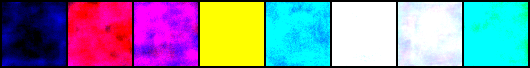

2022-10-06 11:57:22.266518 epoch: 11:
2022-10-06 11:57:22.266681 train


100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s, MSE=0.0376]


2022-10-06 12:03:51.605021 loss 0.01214095
2022-10-06 12:03:51.605373 epoch: 12:
2022-10-06 12:03:51.605413 train


100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s, MSE=0.0192]


2022-10-06 12:10:20.770181 loss 0.01210485
2022-10-06 12:10:20.770581 epoch: 13:
2022-10-06 12:10:20.770620 train


100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s, MSE=0.0181]


2022-10-06 12:16:50.164213 loss 0.01178522
2022-10-06 12:16:50.164586 epoch: 14:
2022-10-06 12:16:50.164624 train


100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s, MSE=0.0123]


2022-10-06 12:23:19.612089 loss 0.01153853
2022-10-06 12:23:19.612580 epoch: 15:
2022-10-06 12:23:19.612616 train


100%|██████████| 1250/1250 [06:29<00:00,  3.21it/s, MSE=0.0125]


2022-10-06 12:29:49.011124 loss 0.01146643
2022-10-06 12:29:49.011559 epoch: 16:
2022-10-06 12:29:49.011607 train


100%|██████████| 1250/1250 [06:32<00:00,  3.18it/s, MSE=0.00546]


2022-10-06 12:36:22.014532 loss 0.01130828
2022-10-06 12:36:22.015024 epoch: 17:
2022-10-06 12:36:22.015065 train


100%|██████████| 1250/1250 [06:30<00:00,  3.20it/s, MSE=0.019]


2022-10-06 12:42:52.919892 loss 0.01164330
2022-10-06 12:42:52.920323 epoch: 18:
2022-10-06 12:42:52.920368 train


100%|██████████| 1250/1250 [06:31<00:00,  3.19it/s, MSE=0.00925]


2022-10-06 12:49:24.877288 loss 0.01107745
2022-10-06 12:49:24.877782 epoch: 19:
2022-10-06 12:49:24.877824 train


100%|██████████| 1250/1250 [06:33<00:00,  3.18it/s, MSE=0.00276]


2022-10-06 12:55:58.209529 loss 0.01097001
2022-10-06 12:55:58.210692 epoch: 20:
2022-10-06 12:55:58.210735 train


100%|██████████| 1250/1250 [06:32<00:00,  3.19it/s, MSE=0.00595]


2022-10-06 13:02:30.344954 loss 0.01168136
2022-10-06 13:02:30.345345 sample 8 new images....


999it [01:44,  9.53it/s]


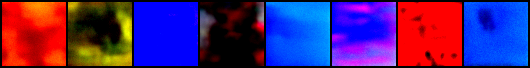

2022-10-06 13:04:15.535913 epoch: 21:
2022-10-06 13:04:15.536091 train


100%|██████████| 1250/1250 [06:26<00:00,  3.23it/s, MSE=0.00796]


2022-10-06 13:10:41.973931 loss 0.01130582
2022-10-06 13:10:41.975394 epoch: 22:
2022-10-06 13:10:41.975455 train


100%|██████████| 1250/1250 [06:25<00:00,  3.25it/s, MSE=0.00564]


2022-10-06 13:17:07.083400 loss 0.01115919
2022-10-06 13:17:07.083825 epoch: 23:
2022-10-06 13:17:07.083866 train


100%|██████████| 1250/1250 [06:23<00:00,  3.26it/s, MSE=0.0125]


2022-10-06 13:23:30.864243 loss 0.01111821
2022-10-06 13:23:30.864599 epoch: 24:
2022-10-06 13:23:30.864636 train


100%|██████████| 1250/1250 [06:26<00:00,  3.23it/s, MSE=0.0101]


2022-10-06 13:29:57.527863 loss 0.01104765
2022-10-06 13:29:57.528347 epoch: 25:
2022-10-06 13:29:57.528389 train


100%|██████████| 1250/1250 [06:31<00:00,  3.19it/s, MSE=0.0151]


2022-10-06 13:36:29.195213 loss 0.01110075
2022-10-06 13:36:29.195587 epoch: 26:
2022-10-06 13:36:29.195623 train


100%|██████████| 1250/1250 [06:36<00:00,  3.15it/s, MSE=0.0146]


2022-10-06 13:43:05.935712 loss 0.01091184
2022-10-06 13:43:05.936104 epoch: 27:
2022-10-06 13:43:05.936150 train


100%|██████████| 1250/1250 [06:32<00:00,  3.19it/s, MSE=0.00638]


2022-10-06 13:49:38.361304 loss 0.01129729
2022-10-06 13:49:38.361763 epoch: 28:
2022-10-06 13:49:38.361805 train


100%|██████████| 1250/1250 [06:32<00:00,  3.19it/s, MSE=0.00386]


2022-10-06 13:56:10.823387 loss 0.01075631
2022-10-06 13:56:10.823763 epoch: 29:
2022-10-06 13:56:10.823800 train


100%|██████████| 1250/1250 [06:32<00:00,  3.18it/s, MSE=0.00641]


2022-10-06 14:02:43.599587 loss 0.01085799
2022-10-06 14:02:43.599941 epoch: 30:
2022-10-06 14:02:43.599994 train


100%|██████████| 1250/1250 [06:32<00:00,  3.19it/s, MSE=0.00585]


2022-10-06 14:09:16.037629 loss 0.01045670
2022-10-06 14:09:16.038945 sample 8 new images....


999it [01:45,  9.48it/s]


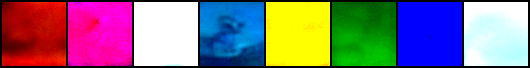

2022-10-06 14:11:01.775346 epoch: 31:
2022-10-06 14:11:01.777571 train


 92%|█████████▏| 1154/1250 [06:00<00:29,  3.21it/s, MSE=0.00651]

In [ ]:
#@title execute the training process
%cd /content/ddpm

#@markdown Input parameters:
runName = "DDPM_Uncondtional" #@param {"type":"string"}
epochs = 500 #@param {"type":"integer"}
batchSize = 8 #@param {"type":"integer"}
imageSize = 64 #@param {"type":"integer"}
datasetPath = "/content/ddpm/dataset" #@param {"type":"string"}
device = "cuda" #@param ["cuda", "cpu"]
lr = 3e-4 #@param {"type":"number"}


class Args():
    def __init__(self):    
        self.run_name = runName
        self.epochs = epochs
        self.batch_size = batchSize
        self.image_size = imageSize
        self.dataset_path = datasetPath
        self.device = device
        self.lr = lr

train(Args())



### References
*  Diffusion Models
 https://github.com/dome272/Diffusion-Models-pytorch/
*  What are Diffusion Models?
 https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
*  The Annotated Diffusion Model
 https://huggingface.co/blog/annotated-diffusion

*  Gaussian distribution is isotropic? https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic

*  Denoising Diffusion Probabilistic Models https://arxiv.org/pdf/2006.11239.pdf
*  Deep Unsupervised Learning using Nonequilibrium Thermodynamics https://arxiv.org/pdf/1503.03585.pdf